# Coursework 1 - Mathematics for Machine Learning

## Due: 25/03/2025

## CID: 02021144

***
***

## Exercise 1: Quick questions [2 points]

#### Question 1:

The bias correction terms in the Adam algorithm are useful during the initial iterations of the algorithm. We initialise both first and second moments to 0 and update them as $\text{moment} = \beta \cdot \text{moment} + (1- \beta){new \, moment}$ for $\beta$ < 1, usually = 0.9 to 0.99. We can see that in the initial stages, the effect of the first few incoming moments are being scaled down by the $(1- \beta)$ factor. Therefore the bias correction term divides the moments by a factor $(1- \beta^t)$ to mitigate this and help the algorithm move quicker in the initial stages. As the number of iterations $t$ grows, the bias correction factor converges to 1, thereby becoming insignificant as the algorithm settles.

#### Question 2:

Stochastic Gradient Descent (SGD) is an extension of gradient descent, designed to reduce computational cost when training dataset size is too large for GPU or system memory. It achieves this by approximating the gradient of the loss function with smaller minibatches. This reduces the number of gradient calculations required per iterative descent step and the size of these minibatches is selected such that they fit within the memory requirements of the system.

#### Question 3:

The idea of Kaiming initializtion is to initialise the weights such that input signals are not exponentially magnified or reduced as they are propagated through the network layers. This can be mathematically stated as $Var(y_L) = Var(y_1)$, meaning the variance of the last layer is the same as variance of the first for a newly initialised network.

In the simplest case we can look at forward propagation for a feed forward Relu network. Let $y_l = W_lx_l$ for the equation of the $l$'th indexed layer with no bias. $y_l$ is composed of $n_l$ multiplications $w_lx_l$ for row vector $w_l$ and column vector $x_l$. Assume elements of $y_l$, $w_l$ and $x_l$ are independent and distributed symmetrically around 0.
$$
Var(y_l) = n_l \, Var(w_lx_l) = n_l \, \mathbb{E}[w_l^2]\mathbb{E}[x_l^2] = n_l \, Var(w_l)\mathbb{E}[x_l^2]
$$

Now we can use the Relu activation to rewrite $x_l$ in terms of $y_{l-1}$:
$$
\mathbb{E}[x_l^2] = \mathbb{E}[Relu(y_{l-1})^2] = \mathbb{E}[(y_{l-1} \cdot \mathbb{1}(y_{l-1} > 0))^2] = \mathbb{E}[y_{l-1}^2 \cdot \mathbb{1}(y_{l-1} > 0)] = \frac{1}{2} \mathbb{E}[y_{l-1}^2] = \frac{1}{2} Var(y_{l-1})
$$

Now we can substitute this back into the variance equation and expand it from layer 1 to L:
$$
Var(y_l) = \frac{1}{2} n_l \, Var(w_l) \, Var(y_{l-1}) \implies Var(y_L) = \left( \prod_{l=2}^{L} \frac{1}{2} n_l \, Var(w_l) \right) \, Var(y_{1})
$$

Now returning to our original goal, if we want $Var(y_L) = Var(y_1)$, requiring $\frac{1}{2} n_l \, Var(w_l) = 1 \quad \forall l > 0$ is sufficient. If we let $w_l$ follow a gaussian distribution and $Var(w_l) = \frac{2}{n_l}$, then $w_l \sim N(0, \frac{2}{n_l})$ fulfils this requirement and $\sigma_l = \sqrt{\frac{2}{n_l}}$.

Therefore the $\sqrt{2}$ factor can be traced back to taking the second moment under Relu from layer to layer. The $\frac{1}{2}$ factor comes out of the fact that $Relu(x)$ is zero for $x < 0$ and all initialization elements are symmetrically distributed around 0.

#### Question 4:

Theorem 4.2 uses the Lipschitz continuity for the proof for Lemma 4.4:
$$
|h(x) - g(x)| = |g(u_s) - g(x)| \leq \rho \|u_s - x\|_2 \leq \epsilon
$$
Where $u_s$ is defined as the corner of the side length $\frac{1}{k}$ half open cube that contains $x$. The $\rho$ Lipschitz continuity of $g$ lets us perform this bound and bound again with $\epsilon$ by construction of $k$.

This lemma is used when considering the following integral from the proof for Theorem 4.2:
$$
\int_{[0, 1)^d} |f(x) - g(x)| \, dx = \int_{[0, 1)^d} |f(x) - h(x)| + |h(x) - g(x)| \, dx \leq \int_{[0, 1)^d} |f(x) - h(x)| + \epsilon
$$

*** 
***

## Exercise 2: [6 points]


### Question 1 [2 points]


Proving $\mathcal{F}_{cos,d}$ is a universal approximator:

1. Each $f \in \mathcal{F}_{cos,d}$ takes the form $\sum_{i=1}^N a_i \cos(\langle c_i, x \rangle + e_i)$:
   - cos is continuous
   - a scaled continuous function is continuous
   - a finite sum of continuous functions is continuous
   - Therefore every $f \in \mathcal{F}_{cos,d}$ is continuous
3. For every $x$, $\cos(0^Tx) = 1 \neq 0$
4. For every $x \neq x'$, let $f(a) = cos((a-x)^T(x'-x)/\|x'-x\|_2^2)$, $f(x) = cos(0) \neq cos(1) = f(x')$. Therefore $\mathcal{F}_{cos,d}$ separates points.
5. Proving $\mathcal{F}_{cos,d}$ is closed under multiplication and vector space operations:

Let $f(x) = \sum_{i=1}^N a_i \cos(\langle c_i, x \rangle + e_i)$ and $g(x) = \sum_{j=1}^M b_j \cos(\langle d_j, x \rangle + f_j)$.

First under vector space operations:
$$
\alpha f(x) + \beta g(x) 
= \sum_{i=1}^N \alpha a_i \cos(\langle c_i, x \rangle + e_i) + \sum_{j=1}^M \beta b_j \cos(\langle d_j, x \rangle + f_j)
= \sum_{k=1}^L\alpha s_k \cos(\langle t_k, x \rangle + u_k) = h(x) \in \mathcal{F}_{cos,d}
$$
where:
- $L = N + M$
- $(s_k) = (\alpha a_1, ...,\alpha a_N, \beta b_1, ..., \beta b_M)$
- $(t_k) = (\alpha c_1, ...,\alpha c_N, \beta d_1, ..., \beta d_M)$
- $(u_k) = (\alpha e_1, ...,\alpha e_N, \beta f_1, ..., \beta f_M)$

So $\mathcal{F}_{cos,d}$ is closed under vector space operations.

Now under multiplication:
$$
f(x) \cdot g(x)
= \left( \sum_{i=1}^N a_i \cos(\langle c_i, x \rangle + e_i) \right) \left( \sum_{j=1}^M b_j \cos(\langle d_j, x \rangle + f_j) \right)
= \sum_{i=1}^N \sum_{j=1}^M a_i b_j \cos(\langle c_i, x \rangle + e_i) \cos(\langle d_j, x \rangle + f_j)
$$

Now using $\cos A \cos B = \frac{1}{2}(\cos(A+B) + \cos(A-B))$
$$
= \sum_{i=1}^N \sum_{j=1}^M \frac{a_i b_j}{2} (\cos(\langle (c_i + d_j), x \rangle + (e_i + f_j)) + \cos(\langle (c_i - d_j), x \rangle + (e_i - f_j)))
$$
$$
= \sum_{i=1}^N \sum_{j=1}^M k_{ij} (m_{ij}(x) + n_{ij}(x))
= \sum_{i=1}^N \sum_{j=1}^M k_{ij} p_{ij}(x) 
= \sum_{i=1}^N q_{i}(x) = r(x) 
\in \mathcal{F}_{cos,d}
$$

Where functions $m_{ij}, n_{ij}, p_{ij}, q_i \in \mathcal{F}_{cos,d}$ with the following definitions
- $k_{ij} = \frac{a_i b_j}{2}$
- $m_{ij}(x) = \cos(\langle (c_i + d_j), x \rangle + (e_i + f_j))$
- $n_{ij}(x) = \cos(\langle (c_i - d_j), x \rangle + (e_i - f_j))$
- $p_{ij}(x) = m_{ij}(x) + n_{ij}(x)$
- $q_{i}(x) = \sum_{j=1}^M k_{ij} p_{ij}(x)$

The last line uses closure under vector operations to reduce the product and show multiplication is also closed.

These four conditions are enough to satisfy Theorem 4.7 (Stone-Weierstrass) which concludes that $\mathcal{F}_{cos,d}$ is a universal approximator.

***

### Question 2 [2 points]

The original model had equation:
$$
f(x) = A_2 \sigma(A_1 x + b_1) = \sum_{i=1}^w (A_w)_i\sigma((A_1)_i x + (b_1)_i)
$$

We will use a $w$ hidden layer network instead to accumulate this sum. We only need width $d+3$. Define the following:
$$
M_1 =
\left[
\begin{array}{ccc}
\ddots &  &  \\
  & I_d &  \\
  &   & \ddots \\ \hline
\dots & (A_1)_1 & \dots \\ \hline
\dots & 0 & \dots \\
\dots & 0 & \dots
\end{array}
\right]
\qquad
M_l =
\left[
\begin{array}{ccc|c|cc}
\ddots &  &  & \vdots & \vdots & \vdots \\
  & I_d &  & 0 & 0 & 0 \\
  &   & \ddots & \vdots & \vdots & \vdots \\ \hline
\dots & (A_1)_l & \dots & 0 & 0 & 0 \\ \hline
\dots & 0 & \dots & (A_2)_{l-1} & 1 & -1 \\
\dots & 0 & \dots & -(A_2)_{l-1} & -1 & 1
\end{array}
\right]
\text{ for } 2 \leq l \leq w
\qquad
B_l = 
\left[
\begin{array}{c}
\vdots \\
0 \\
\vdots \\ \hline
(b_1)_i \\ \hline
0 \\
0 \\
\end{array}
\right]
\text{ for } 1 \leq l \leq w
\qquad
M_{w+1} =
\left[
\begin{array}{ccc|c|cc}
\dots & 0 & \dots & (A_2)_w & 1 & -1
\end{array}
\right]
$$

for
- $M_1 \in \mathbb{R}^{(d+3) \times d}$
- $M_l \in \mathbb{R}^{(d+3) \times (d+3)}$ for $2 \leq l \leq w$
- $M_{w+1} \in \mathbb{R}^{(d+3) \times 1}$
- $B_1 \in \mathbb{R}^{d+3}$ for $1 \leq l \leq w$

Now define:
- $c_i = \sigma((A_1)_i x + (b_1)_i)$
- $s_l = \sum_{i=1}^l (A_2)_i c_i$

It is clear that $s_w = f(x)$. $s_w$ is the variable that we are going to accumulate through the layers.

The first layer can take the original input $x$ and we have $x_1 = \sigma(M_1x + B_1)$.

We can see how each layer evaluates:
$$
\sigma(M_{l+1}x_l + B_{l+1}) =
\sigma \left(
\left[ \begin{array}{ccc|c|cc} \ddots &  &  & \vdots & \vdots & \vdots \\ & I_d &  & 0 & 0 & 0 \\ &   & \ddots & \vdots & \vdots & \vdots \\ \hline \dots & (A_1)_{l+1} & \dots & 0 & 0 & 0 \\ \hline \dots & 0 & \dots & (A_2)_{l} & 1 & -1 \\ \dots & 0 & \dots & -(A_2)_{l} & -1 & 1 \end{array} \right]
\left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline c_{l} \\ \hline \sigma(s_{l-1}) \\ \sigma(-s_{l-1}) \\ \end{array} \right]
+
\left[ \begin{array}{c} \vdots \\ 0 \\ \vdots \\ \hline (b_1)_{l+1} \\ \hline 0 \\ 0 \\ \end{array} \right]
\right)
= \sigma \left( \left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline (A_1)_{l+1} x + (b_1)_{l+1} \\ \hline (A_2)_{l}c_l + \sigma(s_{l-1}) - \sigma(-s_{l-1}) \\ -(A_2)_{l}c_l - \sigma(s_{l-1}) + \sigma(-s_{l-1}) \\ \end{array} \right] \right)
= \sigma \left( \left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline (A_1)_{l+1} x + (b_1)_{l+1} \\ \hline (A_2)_{l}c_l + s_{l-1} \\ -((A_2)_{l}c_l + s_{l-1}) \\ \end{array} \right] \right)
= \left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline c_{l+1} \\ \hline \sigma(s_{l}) \\ \sigma(-s_{l}) \\ \end{array} \right]
= x_{l+1}
$$

Which uses $\sigma(\alpha) - \sigma(-\alpha) = \alpha$ and the fact that $\sigma(x) = x$ because $x \in \mathbb{R}^{[0,1]}$. 

Using this can observe the state of $x_l$ as it goes through the $w$ hidden layers:
$$
x_1 = \left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline c_1 \\ \hline 0 \\ 0 \\ \end{array} \right]
\qquad
x_2 = \left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline c_2 \\ \hline \sigma(s_1) \\ \sigma(-s_1) \\ \end{array} \right]
\qquad
x_3 = \left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline c_3 \\ \hline \sigma(s_2) \\ \sigma(-s_2) \\ \end{array} \right]
\qquad
\dots
\qquad
x_w = \left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline c_w \\ \hline \sigma(s_{w-1}) \\ \sigma(-s_{w-1}) \\ \end{array} \right]
$$

It is important to note how we calculate and store the positive and negative of $s_l$. If we stored only $s_l$ it could get wiped out by the Relu. Therefore we store both and one of them will be zero each time as we go through each Relu.

Finally the output layer evaluates to:
$$
M_{w+1}x_w
= \left[ \begin{array}{ccc|c|cc} \dots & 0 & \dots & (A_2)_w & 1 & -1 \end{array} \right]
\left[ \begin{array}{c} \vdots \\ x \\ \vdots \\ \hline c_w \\ \hline \sigma(s_{w-1}) \\ \sigma(-s_{w-1}) \\ \end{array} \right]
= (A_2)_w c_w + \sigma(s_{w-1}) - \sigma(-s_{w-1}) = (A_2)_w c_w + s_{w-1} = s_w = f(x)
$$
... as desired.

This uses width $d+3$. In order to fulfil width $2d+3 > d+3$, we can pad all $M$ and $B$ matricies with zeros and achieve the same result.

***

### Question 3 [2 points]

In the plot $a$, the training loss steadily decreases. Starting at just under 0.7, the first 200 epochs loss falls faster than the last 300 but both are relatively slow. After 500 epochs the loss is still relatively high at just above 0.1 and the algorithm evidently has more training left to do. The loss curve is veery smooth with no spikes or oscillations. These factors indicate the learning rate is too small and parameter updates are too conservative, resulting in slow model convergence. To improve this convergence, we would increase the learning rate and let the model take larger parameter update steps as this would help the loss fall faster.

In plot $b$, training loss starts high and exhibits large oscillations throughout training. The first 80 epochs show potential convergence but then the loss rises and never meaningfully converges. From epoch 100 onwards, the base loss is around 0.3 with frequent spikes to almost 0.6. This behaviour is indicative of a learning rate that is too high. We can clearly see the model constantly overshoot itself in the loss landscape and jump around without converging smoothly to the minimum. To improve this convergence we would decrease the learning rate so that the model converges more carefully. We might also increase batch size if we can as this would result in less noisy parameter updates.

In plot $c$, the loss starts at 0.6 and falls quickly to 0.1 within the first 50 epochs. For the remaining 450 epochs, the loss slowly and consistently decreases with occasional small oscillations. By the end of 500 epochs the model seems to have converged at a near zero loss which is exactly as desired. The model convergence was stable and efficient compared to the other two plots, indicative of a well chosen learning rate. This convergence is already quite good and there is nothing obvious we might to do improve it. Out of the box suggestions might include using a scheduler to scale down learning rate over a number of epochs. We could also use momentum for perhaps even faster and better convergence.

***
***

## Exercise 3: Implementation [13 points]

In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchsummary

## Part 1: Image classification [4 points]

***
### Question 1 [0.5 point]


Download the dataset from
https://chaladze.com/l5/img/Linnaeus%205%2032X32.rar
and uncompress the .rar dataset to a folder named "Linnaeus_5_32X32" in the current directory.
This folder contains a subfolder "Linnaeus 5 32X32", which contains a test and a train folder with the images of the dataset in 5 different classes: berry, bird, dog, flower, other.

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

# trainset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32\\Linnaeus 5 32X32\\train", transform=transform)
# alternative file paths for Unix systems
trainset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32/Linnaeus 5 32X32/train", transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# testset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32\\Linnaeus 5 32X32\\test", transform=transform)
testset = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32/Linnaeus 5 32X32/test", transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,)

classes = ('berry', 'bird', 'dog', 'flower', 'other')

In [105]:
# dictionary to save one image per class to display
to_display = {cls: None for cls in trainset.classes}

# reverse of class to idx
idx_to_class = {i: c for c, i in trainset.class_to_idx.items()}

i = 0
# loop through training dataset
for img, label in trainset:
    # if we find a class that we have not seen before
    if to_display[idx_to_class[label]] is None:
        # save the image
        to_display[idx_to_class[label]] = img
        i += 1
    # if we have counted all classes, break loop
    if i >= len(trainset.classes):
        break

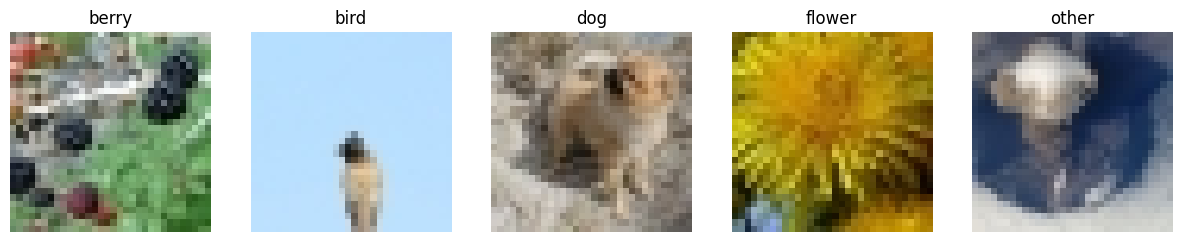

In [107]:
# reverse of transform for displaying
def rescale(img):
    return (img + 1) / 2

# plot images for each class
fig, axs = plt.subplots(1, len(trainset.classes), figsize=(15, 3))
for i in range(len(trainset.classes)):
    cls = trainset.classes[i]
    axs[i].imshow(rescale(to_display[cls].numpy()).transpose(1, 2, 0))
    axs[i].axis('off')
    axs[i].set_title(cls)
plt.show()

### Question 2 [0.5 point]

```
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
)]
```
The above transform has two stages.
1. Take an input image (either a PIL image or numpy array of shape (H, W, C)) and converts it into a torch tensor of shape (C, H, W) whilst scaling from [0, 255] to [0, 1]. 
2. normalise transform applies channel-wise normalisation for each pixel. It computes $x_{norm} = \frac{x-0.5}{0.5}$. This transforms the pixel ranges from [0, 1] to [-1, 1].

Converting to pytorch tensors is needed so that we can carry out pytorch operations e.g. feed through models etc. Scaling and normalising the pixel values to be centred around zero is useful so that all numbers are in a small controlled range and avoid exploding or vanishing values/gradients during training which leads to more efficient convergence.

***
### Question 3 [1 point]

In [3]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        # feature extraction layers. 6 3x3 convolutional layers with 3 maxpooling layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected layers 4096 -> 512 -> 64 -> 5
        self.fc1 = nn.Linear(in_features=4096, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=5)

        # relu activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # cnn
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.mp1(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp2(x)
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.mp3(x)

        # flatten
        x = x.view(-1, 4096)

        # fcn
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

***
### Question 4 [0.5 point]

In [9]:
torchsummary.summary(myCNN().cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

***
### Question 5 [0.5 point]

In [17]:
def train(myCNN, nr_epochs, optimizer ,criterion, trainloader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion.to(device)

    # loop for number of epochs
    for epoch in range(nr_epochs):
        # iterate training loader
        for i, (inputs, labels) in enumerate(trainloader):
            # zero gradients
            optimizer.zero_grad()

            # move to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # process inputs
            outputs = myCNN(inputs)
            # calculate loss
            loss = criterion(outputs, labels)
            # backpropagate
            loss.backward()

            # move back from cpu to save memory
            inputs = inputs.cpu()
            labels = labels.cpu()

            # update parameters
            optimizer.step()

            # print loss every 10 batches
            if i % 10 == 0:
                print('Epoch [{}/{}], Batch {}, Loss: {:.4f}'.format(epoch+1, nr_epochs, i, loss.item()))

        # print loss value for epoch
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, nr_epochs, loss.item()))

    model.cpu()
    criterion.cpu()

***
### Question 6 [0.5 point]

In [18]:
model = myCNN()

# define everything needed for training
n_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# execute trainingmplement a small MLP that takes an output of the pretrained model as input, with
2 output nodes. The ML
train(model, n_epochs, optim, criterion, trainloader)

Epoch [1/30] Batch 0, Loss: 1.6108
Epoch [1/30] Batch 10, Loss: 1.5924
Epoch [1/30] Batch 20, Loss: 1.5868
Epoch [1/30] Batch 30, Loss: 1.5445
Epoch [1/30] Batch 40, Loss: 1.5957
Epoch [1/30], Loss: 1.4787
Epoch [2/30] Batch 0, Loss: 1.4123
Epoch [2/30] Batch 10, Loss: 1.4187
Epoch [2/30] Batch 20, Loss: 1.4966
Epoch [2/30] Batch 30, Loss: 1.4160
Epoch [2/30] Batch 40, Loss: 1.4006
Epoch [2/30], Loss: 1.2692
Epoch [3/30] Batch 0, Loss: 1.2630
Epoch [3/30] Batch 10, Loss: 1.3869
Epoch [3/30] Batch 20, Loss: 1.2470
Epoch [3/30] Batch 30, Loss: 1.3426
Epoch [3/30] Batch 40, Loss: 1.2779
Epoch [3/30], Loss: 1.3316
Epoch [4/30] Batch 0, Loss: 1.3105
Epoch [4/30] Batch 10, Loss: 1.2825
Epoch [4/30] Batch 20, Loss: 1.2103
Epoch [4/30] Batch 30, Loss: 1.2415
Epoch [4/30] Batch 40, Loss: 1.2308
Epoch [4/30], Loss: 1.2679
Epoch [5/30] Batch 0, Loss: 1.2618
Epoch [5/30] Batch 10, Loss: 1.1717
Epoch [5/30] Batch 20, Loss: 1.1005
Epoch [5/30] Batch 30, Loss: 1.2554
Epoch [5/30] Batch 40, Loss: 1.12

In [ ]:
torch.save(model.state_dict(), 'mycnn.pth')

***
### Question 7 [0.5 point]

In [31]:
def accuracy(model, testloader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # initialise correct and total counts per class
    correct = {n: 0 for n in range(5)}
    total = {n: 0 for n in range(5)}

    # set model to evaluate mode
    model.to(device).eval()

    # no gradient context
    with torch.no_grad():
        # iterate test loader
        for inputs, labels in testloader:
            # process inputs
            output = model(inputs.to(device))
            # reduce logits with argmax to find output class
            output_argmax = torch.argmax(output, dim=-1).cpu()

            # process outputs per class
            for u in torch.unique(labels):
                # find indexes for current class
                idxs = labels == output_argmax
                # calculate number of correct classes
                correct_for_class = torch.sum(labels[idxs] == output_argmax[idxs]).item()
                # update correct count for class
                correct[u.item()] += correct_for_class
                # update total count for class
                total[u.item()] += labels.shape[0]

    c = testloader.dataset.class_to_idx
    # iterate classes
    for class_name in testloader.dataset.classes:
        # print accuracy using dictionaries (correct / total)
        print (f" Accuracy for class ’{class_name}’: {correct[c[class_name]] / total[c[class_name]] * 100:.2f}% ")

# load state dict
cnn = myCNN()
cnn.load_state_dict(torch.load('mycnn.pth', weights_only=True))
cnn.eval()

# run accuracy function
accuracy(cnn, testloader)

 Accuracy for class ’berry’: 73.44% 
 Accuracy for class ’bird’: 60.74% 
 Accuracy for class ’dog’: 77.73% 
 Accuracy for class ’flower’: 72.07% 
 Accuracy for class ’other’: 67.03% 


***
## Part 2: Fine-tuning a pretrained model [3.5 points]

### Question 1 [0.5 point]

In [19]:
# same as first train and test loading but for smaller dataset

transform_small = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size_small = 128

# trainset_small = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32_small\\train", transform=transform)
trainset_small = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32_small/train", transform=transform_small)

trainloader_small = torch.utils.data.DataLoader(trainset_small, batch_size=batch_size_small, shuffle=True)

# testset_small = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32_small\\test", transform=transform)
testset_small = torchvision.datasets.ImageFolder(root="Linnaeus_5_32X32_small/test", transform=transform_small)

testloader_small = torch.utils.data.DataLoader(testset_small, batch_size=batch_size_small, shuffle=False,)

***
### Question 2 [1 point]

LogSoftmax: Converts the raw logits (i.e. the unbounded output of the final linear layer) into log probabilities. This step is critical because:

It ensures numerical stability.
It provides inputs in the form that NLLLoss expects.

In [20]:
class myMLP(nn.Module):
    def __init__(self):
        super(myMLP, self).__init__()
        # fully connected layers 5 -> 128 -> 128 -> 2
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

        # relu activation
        self.relu = nn.ReLU()

        # logsoftmax output
        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.logsoftmax(x)
        return x

#### 1. Determine and justify the number of input nodes for the MLP.

We are using the MLP to process the output of the CNN. The CNN has 5 output logits and therefore this must be the number of input nodes to the MLP.

#### 2. We are going to use the negative log likelihood loss for training later, with criterion torch.nn.NLLLoss(). Based on the lecture notes and the PyTorch documentation, find and explain what nonlinear function should we use at the output layer of the MLP. Also explain why this loss function is an appropriate choice for this task.

Based on the use of NLLLoss, it is logical to use LogSoftmax as our nonlinear function. The pytorch documentation for NLLLoss indicate that it expects log probabilities to compute the negative log likelihood. LogSoftmax converts the raw logits into their log probabilities which is exactly as required. The combination of NLLLoss and LogSoftmax benefits from better numerical stability compared to alternatives such as just Softmax. Numerically it is also equivalent to using CrossEntropyLoss which uses LogSoftmax internally. 

In [13]:
torchsummary.summary(myMLP().cuda(), input_size=(5,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             768
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 2]             258
        LogSoftmax-6                    [-1, 2]               0
Total params: 17,538
Trainable params: 17,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


***
### Question 3 [0.5 point]

In [24]:
def fine_tune(myCNN, myMLP, nr_epochs, optimizer, criterion, trainloader):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    myMLP.to(device)
    myCNN.to(device)
    batch_size = trainloader.batch_size
    
    criterion.to(device)

    # freeze cnn
    for param in myCNN.parameters():
        param.requires_grad = False

    # loop for number of epochs
    for epoch in range(nr_epochs):
        # iterate training loader
        for i, (inputs, labels) in enumerate(trainloader):
            # zero gradients
            optimizer.zero_grad()

            # move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get cnn output
            features = myCNN(inputs)
            # run cnn output through mlp
            outputs = myMLP(features)

            # calculate loss
            loss = criterion(outputs, labels)
            # back propagate
            loss.backward()

            # move back to cpu to save gpu memory
            inputs = inputs.cpu()
            labels = labels.cpu()

            # parameter step
            optimizer.step()

            # output every 10 batches
            if i % 10 == 0:
                print('Epoch [{}/{}], Batch {}, Loss: {:.8f}'.format(epoch, nr_epochs, i, loss.item()))

        # print epoch loss
        print('Epoch [{}/{}], Loss: {:.8f}'.format(epoch, nr_epochs, loss.item()))

    myMLP.cpu()
    myCNN.cpu()
    criterion.cpu()

***
### Question 4 [0.5 point]

In [25]:
# load cnn
cnn = myCNN()
cnn.load_state_dict(torch.load('mycnn.pth', weights_only=True))
cnn.eval()

# initialise mlp
mlp = myMLP()

# other things needed for training
n_epochs = 30
optim = torch.optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.NLLLoss()

# fine tune
fine_tune(cnn, mlp, n_epochs, optim, criterion, trainloader_small)

Epoch [0/30], Batch 0, Loss: 0.89327699
Epoch [0/30], Batch 10, Loss: 0.01395314
Epoch [0/30], Loss: 0.00170322
Epoch [1/30], Batch 0, Loss: 0.00123168
Epoch [1/30], Batch 10, Loss: 0.00090814
Epoch [1/30], Loss: 0.00008038
Epoch [2/30], Batch 0, Loss: 0.00022462
Epoch [2/30], Batch 10, Loss: 0.00006717
Epoch [2/30], Loss: 0.00053189
Epoch [3/30], Batch 0, Loss: 0.00227133
Epoch [3/30], Batch 10, Loss: 0.00028253
Epoch [3/30], Loss: 0.00007222
Epoch [4/30], Batch 0, Loss: 0.00109872
Epoch [4/30], Batch 10, Loss: 0.00004144
Epoch [4/30], Loss: 0.00006138
Epoch [5/30], Batch 0, Loss: 0.00068104
Epoch [5/30], Batch 10, Loss: 0.00032267
Epoch [5/30], Loss: 0.00013212
Epoch [6/30], Batch 0, Loss: 0.00000945
Epoch [6/30], Batch 10, Loss: 0.00007837
Epoch [6/30], Loss: 0.00175043
Epoch [7/30], Batch 0, Loss: 0.00131386
Epoch [7/30], Batch 10, Loss: 0.00020252
Epoch [7/30], Loss: 0.00011232
Epoch [8/30], Batch 0, Loss: 0.00001311
Epoch [8/30], Batch 10, Loss: 0.00000779
Epoch [8/30], Loss: 0.0

In [32]:
torch.save(mlp.state_dict(), 'mymlp1.pth')

***
### Question 5 [1 point]

In [6]:
def accuracy_fine_tune(myCNN, myMLP, testloader_small):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    myMLP.to(device).eval()
    myCNN.to(device).eval()

    # correct and total dictionaries per 
    correct = {n: 0 for n in range(2)}
    total = {n: 0 for n in range(2)}

    # to gradient context
    with torch.no_grad():
        # iterate test loader
        for inputs, labels in testloader_small:
            # move inputs to device and process through cnn and mlp and exponentiate to get probabilities
            features = myCNN(inputs.to(device))
            outputs = torch.exp(myMLP(features))

            # argmax to get reduce probabilities to output
            output_argmax = torch.argmax(outputs, dim=-1).cpu()

            # iterate classes
            for u in torch.unique(labels):
                # get indexes for class
                idxs = labels == output_argmax
                # calculate number of correct
                correct_for_class = torch.sum(labels[idxs] == output_argmax[idxs]).item()
                # update correct count
                correct[u.item()] += correct_for_class
                # update total count
                total[u.item()] += labels.shape[0]

    c = testloader_small.dataset.class_to_idx
    # Print the accuracy for each class
    for class_name in testloader_small.dataset.classes :
        print (f" Accuracy for class ’{class_name}’: {correct[c[class_name]] / total[c[class_name]] * 100:.2f}%")

# load both models
cnn = myCNN()
cnn.load_state_dict(torch.load('mycnn.pth', weights_only=True))
cnn.eval()

mlp = myMLP()
mlp.load_state_dict(torch.load('mymlp1.pth', weights_only=True))
mlp.eval()

# accuracy function
accuracy_fine_tune(cnn, mlp, testloader_small)

 Accuracy for class ’dog’: 95.70%
 Accuracy for class ’flower’: 96.39%


#### Comment on the results and compare the accuracy of the fine-tuned model with the accuracy of the CNN model from Part 1.

- The CNN achieved class accuracies ranging from 61% to 78%. In contrast, the fine tuned model with the MLP reached above 95% accuracy on both classes it was trained on.

- This is not a surprising result as we reduced the complexity of the task my removing 3 of 5 categories, reducing the problem to only a binary classification. This makes it inherently easier for the model to distinguish between the two remaining classes due to simpler decision boundaries. 

- The original model's fully connected layers were tasked with identifying 5 different classes. By adding more 'post-processing' parameters in the form of the MLP to classify from extracted features, thereby giving the model more capacity to learn and resulting in high accuracies.

- It is evident that the CNN on its own struggled to generalise well on its more challenging dataset. The greatly improved accuracies with the fine tuning indicate that the feed forward layers of the CNN were inadequate for the scale of the original task. On the other hand, the feature extraction layers of the CNN were useful in the fine tuning and show that they learnt well.

- Training the CNN's feature extraction layers on a broader dataset was probably beneficial as it was exposed to a richer set of features, shapes and objects, therefore feeding the fine-tuned MLP better extracted features than if the CNN was only trained on the two dog and flower classes.

- The CNN started at a high loss and steadily decreased over the epochs, showing some variability with occasional increases and decreases. This reflects the complexity of it's original task and show how the feed forward layers int the original model were struggling. In contrast, the loss for the fine tuned MLP drops rapidly to near 0, indicating that the binary classification problem was learned very quickly, meaning a larger feed forward classifier was easily able to capture the differences between only two classes.

- We might have has concerns about overfitting given the training loss of the MLP being near zero, however the test accuracies show us that this the model generalised well.

***
## Part 3: Adversarial attacks [4.5 points]

***
### Question 1 [1 point]

In [7]:
def adversarial(myCNN, myMLP, image, label, epsilon=0.01):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # move models to device
    myCNN.to(device)
    myMLP.to(device)

    # make a clone of the image and move it to device
    image = image.clone().to(device)

    # set models to evaluation mode
    myCNN.eval()
    myMLP.eval()

    # NLLLoss function
    criterion = nn.NLLLoss()

    # hyperparameters
    nr_steps = 10
    mu = 1.0
    alpha = epsilon / nr_steps

    # momentum term
    g = torch.zeros_like(image, device=device)

    # we will use x in the loop. enable gradient tracking
    x = image.detach().requires_grad_()
    x.to(device)

    # format label as tensor
    lbl = torch.as_tensor(label, device=device).unsqueeze(0).long().to(device)

    # Loop over the number of steps and update the image
    for i in range(nr_steps):
        # zero gradients
        myCNN.zero_grad()
        myMLP.zero_grad()

        # forward pass
        output = myCNN(x.unsqueeze(0))
        output = myMLP(output)

        # compute loss
        loss = criterion(output, lbl)

        # backpropagate with respect to x
        loss.backward()
        grad = x.grad

        # update momentum with L1-norm normalization
        grad_norm = torch.norm(grad, p=1) + 1e-8  # avoid div-by-zero
        g = mu * g + grad / grad_norm

        # parameter step with sign of momentum
        x = x + alpha * torch.sign(g)

        # reset gradients on x
        x = x.detach().requires_grad_()

    # final adversarial image
    adv_image = x.detach()
    adv_image_cpu = adv_image.cpu()

    # get probability of adversarial image
    output = myCNN(adv_image.unsqueeze(0))
    output = myMLP(output)
    p = torch.exp(output)[0, label].item()

    return adv_image_cpu, p


### Question 2 [1 point]

#### Explain the role of the parameter epsilon in the function and how the algorithm is working.

Epsilon ($\epsilon$) is the 'size of the perturbation'. Intuitively it defines a search space around x, the maximum allowed change under the $L_\infty$ norm, in which to find an adversarial example. The idea is that within this small $\epsilon$-radius of our starting image, we can find a similar adversarial image which gives us a different output from the classifier and this adversarial example is at most '$\epsilon$ far' from the original image. Higher epsilons have higher success rates in finding an adversarial example but at the cost of imperceptibility (i.e. the adverse example will be more different to the original).

The algorithm starts by initialising the following variables. $\alpha = \frac{\epsilon}{T}$, where T is the number of iterations, is set as a step size such that even if we travel in the same direction T times, we are at most $\epsilon$ from the starting image and ensuring we stay within the $\epsilon-L_\infty$ ball. $g_0=0$ initialises our momentum variable to 0. And $x^*_0=x$ begins our search for the adversarial image at the original image.

The algorithm loops for $0 \leq t \leq T-1$:
- In each iteration it classifies the current image $x^*_t$ and computes the gradient of the loss function (in our case NLLLoss) with respect to $x^*_t$.
- This gradient ($grad$) is then used to update the momentum variable as follows: $g_{t+1} = \mu \cdot g_t + \frac{grad}{\| grad \|_1}$. The previous momentum is multiplied by a decay variable $\mu$ and the newest normalised gradient is added. The decay variable determines how strongly the momentum rememberes gradients from far in the past. By building this momentum, the algorithm can better navigate the loss landscape, i.e. noisy or oscillating gradients, in search of the adversarial example.
- Then the sign of the momentum $g_{t+1}$ is used to update the current image as follows: $x^*_{t+1} = x^*_t + \alpha \cdot \text{sign}(g_{t+1})$. The effect of the momentum can be understood with a simple example, e.g. if there is lots of initial momentum in the positive direction and then a small amount in the negative direction, we can see how the momentum would likely still have positive sign. Therefore the algorithm would not react to the small negative gradient and continue the search in the positive direction.

After T iterations, the current image is taken as the adversarial image.

***
### Question 3 [0.5 point]

In [46]:
# pick image from test dataset
im, l = testset_small[6]
# get adversarial image
adv, p = adversarial(cnn, mlp, im, l, epsilon=0.05)
p

0.0004589585878420621

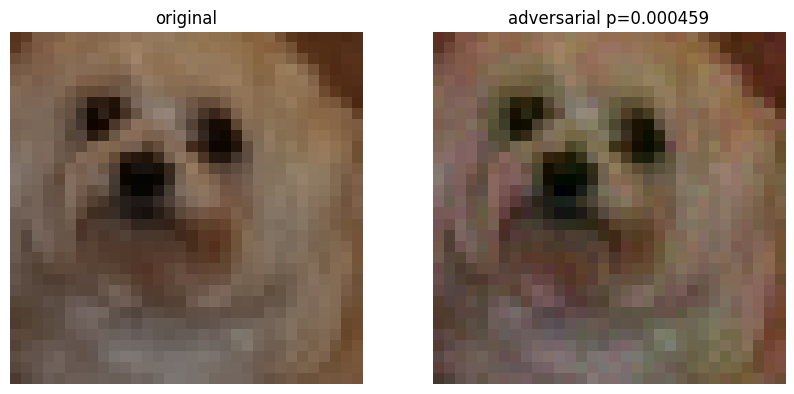

In [47]:
# same rescale function but with a clamp
def rescale(img):
    return (torch.clamp(img, -1, 1) + 1) / 2

# reformat images
im_ = rescale(im).detach().numpy().transpose(1, 2, 0)
adv_ = rescale(adv).detach().numpy().transpose(1, 2, 0)

# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im_)
ax[1].imshow(adv_)
ax[0].set_title("original")
ax[1].set_title(f"adversarial p={p:.6f}")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

***
### Question 4 [0.5 point]

In [45]:
def accuracy_adversarial(myCNN, myMLP, testloader_small, epsilon):
    total_correct = 0
    total_attacked = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    myCNN = myCNN.to(device)
    myMLP = myMLP.to(device)

    # iterate test loader
    for data in testloader_small:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # evaluate images
        outputs = myCNN.forward(images)
        outputs = torch.exp(myMLP(outputs))
        output_argmax = torch.argmax(outputs, dim=-1)
        # get correct indexes
        correct = (output_argmax == labels)

        # loop over classified correctly iamges in batch
        for im, lbl in zip(images[correct], labels[correct]):
            # update correct count
            total_correct += 1
            # generate an adversarial example
            adv, p = adversarial(myCNN, myMLP, im, lbl, epsilon)
            # check if the attack was successful
            if p < 0.5:
                total_attacked += 1

    return total_attacked / total_correct
    
success_rate = accuracy_adversarial(cnn, mlp, testloader_small, 0.05)
print(f'Success rate at epsilon=0.05: {success_rate:.5f}')

Success rate at epsilon=0.05: 0.67708


***
### Question 5 [1 point]

In [29]:
# defined epsilons
es = [0.02, 0.04, 0.06, 0.08, 0.1]
# run adversarial accuracy for each epsilon
adv_success_rates = [accuracy_adversarial(cnn, mlp, testloader_small, e) for e in es]

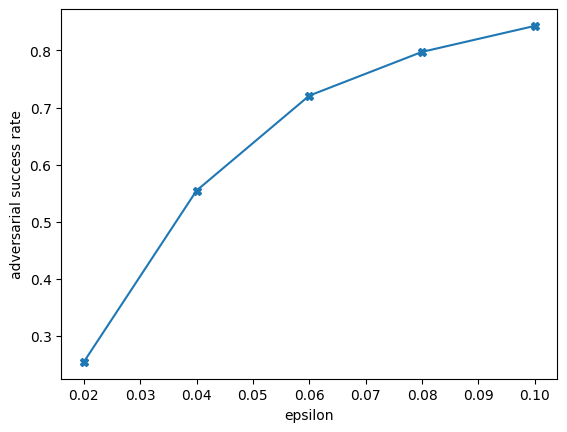

[(0.02, 0.2545454545454545),
 (0.04, 0.5545454545454546),
 (0.06, 0.7207792207792207),
 (0.08, 0.7974025974025974),
 (0.1, 0.8428571428571429)]

In [115]:
# plot success rates over epsilons
plt.plot(es, adv_success_rates, marker='X')
plt.xlabel('epsilon')
plt.ylabel('adversarial success rate')
plt.show()

# show epsilon and success rate pairs
list(zip(es, adv_success_rates))

#### comment on results

The trend is that the success rate of finding an adversarial image grows with $\epsilon$. From $\epsilon=0.02$ to $0.06$, there is quite a sharp increase from 25% to 72%, after which it plateaus to 84% at $\epsilon=0.1$.

This outcome is expected. As explained in the description of the algorithm, $\epsilon$ defines the $L_\infty$ ball around the original image (pixel-wise) in which we can search for an adversarial example. Higher epsilon will naturally result in higher success rate due to the fact we have a wider search radius and we can stray further from the original in search of an image that the classifier thinks is different. However, if we compared successful examples at $\epsilon=1$ and $\epsilon=0.05$ to the original, the $\epsilon=0.05$ example would likely be more similar and be considered a better adversarial example as it was able to fool the classifier with less changes to the input.

The rapid increase at smaller epsilons indicate that the model is robust at these small epsilons but quickly becomes vulnerable to attack as epsilon grows. The plateauing curve shows diminishing returns past $\epsilon=0.1$.

***
### Question 6 [0.5 point]

#### Comment on the impact of adversarial attacks in real-world applications and discuss possible ways to mitigate them. (Machine learning researchers are usually required to include a broader impact statement in their papers about potential consequences of their work, which is why I’m including this question)

Adversarial attacks can have an impact anywhere that machine learning models are deployed in the real world, especially in security and privacy sentitive settings. E.g.: 
- Autonomous vehicles may not decide to brake at the sight due to the mis-classification of a human or obstacle on the road in the object detection software.
- Medical diagnosis software used to scan MRIs and X-rays. A segmentation model can fail to identify a tumor or hairline fracture in an image and thereby resulting in a critital mis-diagnosis of the patient.
- Biometric authentication systems must be absolutely robust to small perturbations in input fingerprint/facial scan so as to not allow for unauthorised access.

Each of the above examples could have widespread and detremental impact if the adversarial attacks are not properly accounted for in the deployment of these ml models. Therefore it is essential that these developers investivate the robustness of their models.

There are many ways of mitigating these adversarial attacks: E.g.:
- Training/tuning models on adversarially collected images. This method allows the model to learn from its mistakes and define better decision boundaries between classes, becoming more robust against small perturbations in its input. This method might take time and effort to collect enough examples and then fine tune the model.
- Training with augmentation e.g. cropping, resizing, adding small amounts of noise, random colour scale adjustments. Used in the appropriate setting for images, e.g. our example above would have worked, augmentations work as a regularisation and makes the model more robust to small insignificant changes that it might have otherwise been fooled by. This method has close to no additional cost at training time and none at evaluation time. 
- Ensemble models. This method runs multiple trained versions of the model, usually in parallel, and combines them to create an output. E.g. out of 5 models, 4 classify the image as class 3 and 1 classifies as class 2, the overall vote would lean in favour of class 4. We can easily see how this would make it harder for adversarial examples to fool more than one model. You could also use ensemble models to run confidence checks and evaluating statistical significance of outcomes. However this comes at a large cost of not only storing but also running computation on all of these unique models.
- Monte-carlo dropout. Models can be designed with dropout layers. Inference on the input can be run multiple times, each time giving the dropout layers a chance to regularise the model differently. We can therefore use this one model in the same way as the ensemble models described previously.